# Library

In [1]:
import os
import random
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#os.environ['TF_DETERMINISTIC_OPS'] = '1'
plt.rcParams["font.family"] = "Malgun Gothic"  

In [2]:
# 시드 고정
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Prep

### 긍정 부정 중립

In [3]:
## 감성분석 x
df0 = pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\data\df_investing2.csv")

## 감성분석 o 

# 뉴스 감정 분석(긍정 부정 중립, 전체, 95, 90)
df1= pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\modeling_data\news_3class_all.csv")
df2= pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\modeling_data\news_3class_95_score.csv")
df3= pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\modeling_data\news_3class_90_score.csv")

# 뉴스 감정 분석(긍정 부정 , 전체, 95, 90)
df4= pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\modeling_data\news_2class_all.csv")
df5= pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\modeling_data\news_2class_95_score.csv")
df6= pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\modeling_data\news_2class_90_score.csv")

# 댓글 감정 분석(긍정 부정 , 전체, 90)
df7= pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\modeling_data\comment_score.csv")
df8= pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\modeling_data\comment_score_0.9.csv")

# 댓글 감정 분석(긍정 부정 , 전체, 90) + 댓글 갯수
df9= pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\modeling_data\comment_score_with_count.csv")
df10= pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\modeling_data\comment_score_0.9_with_count.csv")

In [4]:
def eda_basic_info(df, df_name="DataFrame"):
    print(f"\n===== {df_name} =====")
    print("Head (5 rows):")
    display(df.head())
    
    print("\nInfo:")
    print(df.info())
    
    print("\nDescribe (numeric):")
    display(df.describe())
    
    print("\nNull counts:")
    print(df.isnull().sum())
    
    print("="*40)

In [17]:
eda_basic_info(df10, "check")


===== check =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,...,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,comment_score_0.9,total_comments
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,644550000.0,70.99,2605.39,42573.73,...,5906.94,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-0.666344,17.0
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,814130000.0,70.08,2620.00,42992.21,...,5970.84,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-1.456628,53.0
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,829290000.0,69.53,2634.43,43325.80,...,6037.59,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.094914,38.0
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,645100000.0,69.92,2613.20,43297.03,...,6040.04,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-0.338810,23.0
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,657710000.0,69.34,2612.93,42906.95,...,5974.07,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-0.752439,14.0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1186 non-null   object 
 1   USD_KRW 종가         1186 non-null   float64
 2   USD_KRW 시가         1186 non-null   float64
 3   KOSPI 종가           1186 non-null   float64
 4   KOSPI 거래량          1186 non-null   float64
 5   KOSDAQ 종가          1186 non-null   float64
 6   KOSDAQ 거래량         1186 non-null   float64
 7   WTI Price          1186 non-null   float64
 8   XAU Price          1186 non-null   float64
 9   DJI 종가             1186 non-null   float64
 10  DJI 거래량            1186 non-null   float64
 11  SP500 종가           1186 non-null   float64
 12  M1                 1186 non-null   float64
 13  M2                 1186 non-null   float64
 14  한국 정책금리            1186 non-null   float64
 15  미국 정책금리            1186 non-null   float64
 16  CPI              

,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,comment_score_0.9,total_comments
count,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1186.000000,1186.00000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000
mean,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,3.687432e+08,4250.179671,1219.394587,3616.388458,2.037789,2.60763,2.811298,111.501433,5333.790894,0.000000,15.913153
std,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,1.128756e+08,764.021938,103.680673,347.336672,1.303587,2.31595,1.658261,7.401748,4255.906435,1.000422,14.792348
min,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,1.170400e+08,2237.400000,944.306400,2935.640300,0.500000,0.25000,-0.200000,98.930000,-4205.000000,-3.679656,0.000000
25%,1181.822500,1182.460000,2399.310000,4.629025e+08,762.185000,9.524700e+08,62.090000,1778.307500,31022.087500,3.016050e+08,3810.150000,1184.088000,3309.121000,0.548387,0.25000,1.425000,103.890000,1862.000000,-0.606078,7.000000
50%,1265.610000,1266.325000,2568.480000,6.137650e+08,847.505000,1.170000e+09,73.735000,1870.390000,33913.620000,3.433250e+08,4200.010000,1221.110000,3718.332800,1.750000,1.75000,2.700000,116.270000,6365.000000,0.074954,11.000000
75%,1333.020000,1333.395000,2758.637500,8.662025e+08,919.412500,1.500000e+09,82.030000,1985.455000,35627.822500,4.021650e+08,4591.015000,1287.187300,3843.786700,3.500000,5.25000,3.800000,117.500000,7438.000000,0.711170,21.000000
max,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,1.220000e+09,6090.270000,1371.920900,4183.535400,3.500000,5.50000,6.300000,119.560000,13096.000000,1.442974,112.000000



Null counts:
date                 0
USD_KRW 종가           0
USD_KRW 시가           0
KOSPI 종가             0
KOSPI 거래량            0
KOSDAQ 종가            0
KOSDAQ 거래량           0
WTI Price            0
XAU Price            0
DJI 종가               0
DJI 거래량              0
SP500 종가             0
M1                   0
M2                   0
한국 정책금리              0
미국 정책금리              0
CPI                  0
PPI                  0
경상수지                 0
comment_score_0.9    0
total_comments       0
dtype: int64


# Prep 2(VIF, PCA, NONE)

In [18]:
# VIF
def reduce_vif(df, thresh=10.0):
    variables = df.columns.tolist()
    dropped = True
    while dropped:
        dropped = False
        vif_data = pd.DataFrame()
        vif_data["feature"] = variables
        vif_data["VIF"] = [variance_inflation_factor(df[variables].values, i) for i in range(len(variables))]
        max_vif = vif_data["VIF"].max()
        if max_vif > thresh:
            max_feature = vif_data.sort_values("VIF", ascending=False)["feature"].iloc[0]
            print(f"Dropping {max_feature} with VIF = {max_vif:.2f}")
            variables.remove(max_feature)
            dropped = True
    return df[variables]

In [19]:
# ===== 시퀀스 데이터 생성 함수 =====
def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i : i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

In [20]:
# 데이터 전처리 - PCA, pca_n_components 몇으로 설정? / VIF, vif_threshold 몇으로 설정? / NONE 버전
def prepare_data(df, method="none", window_size=5, vif_threshold=10, pca_n_components=0.99):
    target_column = 'USD_KRW 종가'
    columns_to_drop = ['date', target_column]
    
    # 독립변수와 종속변수 분리
    features = df.drop(columns=columns_to_drop)
    # 원래 변수 이름 저장 
    feature_names = list(features.columns)
    target = df[target_column].values
    
    # VIF 버전: 다중공선성이 높은 변수 제거 후 변수 이름 업데이트
    if method == "vif":
        features = reduce_vif(features, thresh=vif_threshold)
        feature_names = list(features.columns)
    
    # numpy array로 변환
    features_array = features.values
    
    # 스케일링
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    features_scaled = scaler_x.fit_transform(features_array)
    target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))
    
    # PCA 버전: 차원 축소
    if method == "pca":
        pca = PCA(n_components=pca_n_components)
        features_scaled = pca.fit_transform(features_scaled)
        # print("PCA 적용:")
        # print(f"  원래 변수 개수: {len(feature_names)} -> 주성분 개수: {pca.n_components_}")
        # print("  각 주성분에 대한 변수 기여도 (loadings):")
        # for i, component in enumerate(pca.components_):
        #     loadings = {feature_names[j]: component[j] for j in range(len(feature_names))}
        #     sorted_loadings = sorted(loadings.items(), key=lambda x: abs(x[1]), reverse=True)
        #     print(f"  주성분 {i+1} (설명분산: {pca.explained_variance_ratio_[i]*100:.2f}%):")
        #     for feat, loading in sorted_loadings:
        #         print(f"    {feat}: {loading:.4f}")
    
    X, y = create_sequences(features_scaled, target_scaled, window_size)
    
    # 시간 순서대로 학습/테스트 분할 (80:20)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler_y

In [22]:
# target_column = 'USD_KRW 종가'
# columns_to_drop = ['date', target_column]
# features = df.drop(columns=columns_to_drop)

# # 스케일링
# scaler = MinMaxScaler()
# features_scaled = scaler.fit_transform(features.values)

# # PCA 수행
# pca = PCA().fit(features_scaled)
# cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# # 누적 설명 분산 그래프 그리기
# plt.figure(figsize=(8, 5))
# plt.plot(cumulative_variance, marker='o')
# plt.xlabel("주성분 수")
# plt.ylabel("누적 설명 분산")
# plt.axhline(y=0.95, color='r', linestyle='--', label='95% 기준')
# plt.axhline(y=0.99, color='g', linestyle='--', label='99% 기준')
# plt.title("PCA 누적 설명 분산")
# plt.legend()
# plt.show()

# # 주성분 수 확인
# # n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
# # print(f"95% 설명 분산을 위해 필요한 주성분 수: {n_components_95}\n")

# # # 각 주성분에 대한 변수 기여도 출력
# # print("각 주성분의 변수 기여도 (Loadings):")
# # for i in range(n_components_95):
    
# #     loadings = pd.Series(pca.components_[i], index=features.columns)
# #     loadings_sorted = loadings.reindex(loadings.abs().sort_values(ascending=False).index)
# #     print(f"\n주성분 {i+1} (설명 분산: {pca.explained_variance_ratio_[i]*100:.2f}%):")
# #     print(loadings_sorted)

In [23]:
# target_column = 'USD_KRW 종가'
# columns_to_drop = ['date', target_column]
# features = df.drop(columns=columns_to_drop)

# # VIF 계산 함수 정의
# def calculate_vif(df):
#     vif_data = pd.DataFrame()
#     vif_data["변수"] = df.columns
#     vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
#     return vif_data

# # VIF 계산
# vif_df = calculate_vif(features)

# # 내림차순 정렬
# vif_sorted = vif_df.sort_values("VIF", ascending=False)
# print("각 변수의 VIF 값:")
# print(vif_sorted)

# # 시각화
# plt.figure(figsize=(10, 6))
# plt.bar(vif_sorted["변수"], vif_sorted["VIF"], color='skyblue')
# plt.xlabel("변수")
# plt.ylabel("VIF")
# plt.title("각 변수의 VIF")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# Modeling

In [24]:
def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn_lstm(input_shape):
    model = Sequential([
        Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn_gru(input_shape):
    model = Sequential([
        Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        GRU(50, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [25]:
# 모델 학습 및 예측 결과 
def train_models_for_method(df, method="none", window_size=5, epochs=50, batch_size=16):
    # 데이터 전처리
    X_train, X_test, y_train, y_test, scaler_y = prepare_data(df, method=method, window_size=window_size)
    input_shape = (X_train.shape[1], X_train.shape[2])
    y_test_inv = scaler_y.inverse_transform(y_test)
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    results = {}  # 모델별 평가 지표와 예측값 저장
    # LSTM 모델
    model = build_lstm(input_shape)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
    pred = scaler_y.inverse_transform(model.predict(X_test))
    mse_val = mean_squared_error(y_test_inv, pred)
    mape_val = mean_absolute_percentage_error(y_test_inv, pred) * 100
    results['LSTM'] = {'metrics': {'mse': mse_val, 'mape': mape_val}, 'predictions': pred}
    
    # GRU 모델
    model = build_gru(input_shape)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
    pred = scaler_y.inverse_transform(model.predict(X_test))
    mse_val = mean_squared_error(y_test_inv, pred)
    mape_val = mean_absolute_percentage_error(y_test_inv, pred) * 100
    results['GRU'] = {'metrics': {'mse': mse_val, 'mape': mape_val}, 'predictions': pred}
    
    # CNN-LSTM 모델
    model = build_cnn_lstm(input_shape)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
    pred = scaler_y.inverse_transform(model.predict(X_test))
    mse_val = mean_squared_error(y_test_inv, pred)
    mape_val = mean_absolute_percentage_error(y_test_inv, pred) * 100
    results['CNN-LSTM'] = {'metrics': {'mse': mse_val, 'mape': mape_val}, 'predictions': pred}
    
    # CNN-GRU 모델
    model = build_cnn_gru(input_shape)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
    pred = scaler_y.inverse_transform(model.predict(X_test))
    mse_val = mean_squared_error(y_test_inv, pred)
    mape_val = mean_absolute_percentage_error(y_test_inv, pred) * 100
    results['CNN-GRU'] = {'metrics': {'mse': mse_val, 'mape': mape_val}, 'predictions': pred}
    
    return results, y_test_inv

In [26]:
# 전체 실험 실행
def run_experiments(df, window_size=5, epochs=50, batch_size=16):
    methods = ['none', 'vif', 'pca']
    final_results = {}  # 각 전처리 방식별 결과 저장
    for method in methods:
        print(f"\n==== Processing method: {method.upper()} ====")
        model_results, y_test_inv = train_models_for_method(df, method=method, window_size=window_size, epochs=epochs, batch_size=batch_size)
        final_results[method] = {'models': model_results, 'y_test_inv': y_test_inv}
    return final_results

In [27]:
# 그래프 출력 
def plot_time_series_predictions(y_test_inv, predictions, method):
    plt.figure(figsize=(12,6))
    plt.plot(y_test_inv, label='Actual')
    for model_name, data in predictions.items():
        plt.plot(data['predictions'], label=model_name)
    plt.title(f'USD_KRW 종가 예측 결과 비교 ({method.upper()} 전처리)')
    plt.xlabel('Time Step')
    plt.ylabel('USD_KRW 종가')
    plt.legend()
    plt.show()

# Result

In [28]:
df0['date'] = pd.to_datetime(df0['date'])
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
df3['date'] = pd.to_datetime(df3['date'])
df4['date'] = pd.to_datetime(df4['date'])
df5['date'] = pd.to_datetime(df5['date'])
df6['date'] = pd.to_datetime(df6['date'])
df7['date'] = pd.to_datetime(df7['date'])
df8['date'] = pd.to_datetime(df8['date'])
df9['date'] = pd.to_datetime(df9['date'])
df10['date'] = pd.to_datetime(df10['date'])

In [29]:
experiment_results_df0 = run_experiments(df0, window_size=5, epochs=50, batch_size=16)
experiment_results_df1 = run_experiments(df1, window_size=5, epochs=50, batch_size=16)
experiment_results_df2 = run_experiments(df2, window_size=5, epochs=50, batch_size=16)
experiment_results_df3 = run_experiments(df3, window_size=5, epochs=50, batch_size=16)
experiment_results_df4 = run_experiments(df4, window_size=5, epochs=50, batch_size=16)
experiment_results_df5 = run_experiments(df5, window_size=5, epochs=50, batch_size=16)
experiment_results_df6 = run_experiments(df6, window_size=5, epochs=50, batch_size=16)
experiment_results_df7 = run_experiments(df7, window_size=5, epochs=50, batch_size=16)
experiment_results_df8 = run_experiments(df8, window_size=5, epochs=50, batch_size=16)
experiment_results_df9 = run_experiments(df9, window_size=5, epochs=50, batch_size=16)
experiment_results_df10 = run_experiments(df10, window_size=5, epochs=50, batch_size=16)


==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43563.43
Dropping PPI with VIF = 8287.29
Dropping M1 with VIF = 2995.95
Dropping DJI 종가 with VIF = 2395.88
Dropping KOSPI 종가 with VIF = 707.48
Dropping 한국 정책금리 with VIF = 518.85
Dropping XAU Price with VIF = 388.21
Dropping SP500 종가 with VIF = 130.56
Dropping USD_KRW 시가 with VIF = 97.60
Dropping WTI Price with VIF = 58.17
Dropping KOSDAQ 종가 with VIF = 42.20
Dropping KOSDAQ 거래량 with VIF = 14.68


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43563.45
Dropping PPI with VIF = 8287.74
Dropping M1 with VIF = 2995.95
Dropping DJI 종가 with VIF = 2395.89
Dropping KOSPI 종가 with VIF = 708.73
Dropping 한국 정책금리 with VIF = 518.93
Dropping XAU Price with VIF = 389.56
Dropping SP500 종가 with VIF = 130.69
Dropping USD_KRW 시가 with VIF = 97.60
Dropping WTI Price with VIF = 58.55
Dropping KOSDAQ 종가 with VIF = 42.23
Dropping KOSDAQ 거래량 with VIF = 14.70


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43563.61
Dropping PPI with VIF = 8287.58
Dropping M1 with VIF = 2996.51
Dropping DJI 종가 with VIF = 2395.89
Dropping KOSPI 종가 with VIF = 708.50
Dropping 한국 정책금리 with VIF = 518.99
Dropping XAU Price with VIF = 389.48
Dropping SP500 종가 with VIF = 130.76
Dropping USD_KRW 시가 with VIF = 97.63
Dropping WTI Price with VIF = 58.42
Dropping KOSDAQ 종가 with VIF = 42.22
Dropping KOSDAQ 거래량 with VIF = 14.70


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43570.02
Dropping PPI with VIF = 8287.29
Dropping M1 with VIF = 2996.30
Dropping DJI 종가 with VIF = 2396.18
Dropping KOSPI 종가 with VIF = 709.05
Dropping 한국 정책금리 with VIF = 518.95
Dropping XAU Price with VIF = 389.50
Dropping SP500 종가 with VIF = 130.80
Dropping USD_KRW 시가 with VIF = 97.61
Dropping WTI Price with VIF = 58.35
Dropping KOSDAQ 종가 with VIF = 42.22
Dropping KOSDAQ 거래량 with VIF = 14.70


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43563.62
Dropping PPI with VIF = 8288.89
Dropping M1 with VIF = 2997.38
Dropping DJI 종가 with VIF = 2395.97
Dropping KOSPI 종가 with VIF = 708.84
Dropping 한국 정책금리 with VIF = 519.06
Dropping XAU Price with VIF = 389.40
Dropping SP500 종가 with VIF = 130.64
Dropping USD_KRW 시가 with VIF = 97.61
Dropping WTI Price with VIF = 58.48
Dropping KOSDAQ 종가 with VIF = 42.21
Dropping KOSDAQ 거래량 with VIF = 14.69


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43594.53
Dropping PPI with VIF = 8288.84
Dropping M1 with VIF = 3003.82
Dropping DJI 종가 with VIF = 2395.93
Dropping KOSPI 종가 with VIF = 708.44
Dropping 한국 정책금리 with VIF = 520.31
Dropping XAU Price with VIF = 388.35
Dropping SP500 종가 with VIF = 130.91
Dropping USD_KRW 시가 with VIF = 97.60
Dropping WTI Price with VIF = 58.20
Dropping KOSDAQ 종가 with VIF = 42.21
Dropping KOSDAQ 거래량 with VIF = 14.68


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43568.57
Dropping PPI with VIF = 8301.12
Dropping M1 with VIF = 2996.79
Dropping DJI 종가 with VIF = 2396.80
Dropping KOSPI 종가 with VIF = 708.98
Dropping 한국 정책금리 with VIF = 519.93
Dropping XAU Price with VIF = 389.40
Dropping SP500 종가 with VIF = 131.40
Dropping USD_KRW 시가 with VIF = 97.62
Dropping WTI Price with VIF = 58.79
Dropping KOSDAQ 종가 with VIF = 42.22
Dropping KOSDAQ 거래량 with VIF = 14.73


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43645.49
Dropping PPI with VIF = 8301.57
Dropping M1 with VIF = 3006.47
Dropping DJI 종가 with VIF = 2408.26
Dropping KOSPI 종가 with VIF = 710.90
Dropping 한국 정책금리 with VIF = 522.22
Dropping XAU Price with VIF = 390.58
Dropping SP500 종가 with VIF = 132.12
Dropping USD_KRW 시가 with VIF = 97.73
Dropping WTI Price with VIF = 58.44
Dropping KOSDAQ 종가 with VIF = 42.34
Dropping KOSDAQ 거래량 with VIF = 14.70


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43587.14
Dropping PPI with VIF = 8291.77
Dropping M1 with VIF = 2997.50
Dropping DJI 종가 with VIF = 2395.92
Dropping KOSPI 종가 with VIF = 708.96
Dropping 한국 정책금리 with VIF = 520.18
Dropping XAU Price with VIF = 388.73
Dropping SP500 종가 with VIF = 135.75
Dropping USD_KRW 시가 with VIF = 97.72
Dropping WTI Price with VIF = 58.64
Dropping KOSDAQ 종가 with VIF = 42.31
Dropping KOSDAQ 거래량 with VIF = 14.70


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43706.90
Dropping PPI with VIF = 8964.73
Dropping M1 with VIF = 3061.43
Dropping DJI 종가 with VIF = 2475.64
Dropping KOSPI 종가 with VIF = 717.44
Dropping 한국 정책금리 with VIF = 522.64
Dropping XAU Price with VIF = 392.82
Dropping SP500 종가 with VIF = 132.42
Dropping USD_KRW 시가 with VIF = 106.49
Dropping WTI Price with VIF = 59.73
Dropping KOSDAQ 종가 with VIF = 43.62
Dropping KOSDAQ 거래량 with VIF = 14.76


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43622.93
Dropping PPI with VIF = 8818.75
Dropping M1 with VIF = 3076.82
Dropping DJI 종가 with VIF = 2435.67
Dropping KOSPI 종가 with VIF = 721.19
Dropping 한국 정책금리 with VIF = 520.62
Dropping XAU Price with VIF = 392.65
Dropping SP500 종가 with VIF = 136.24
Dropping USD_KRW 시가 with VIF = 106.93
Dropping WTI Price with VIF = 60.08
Dropping KOSDAQ 종가 with VIF = 43.33
Dropping KOSDAQ 거래량 with VIF = 14.73


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [31]:
print("===== 모델 평가 결과 비교 =====")
rows = []
for dataset_name, experiment_results in zip(['df0', 'df1','df2','df3','df4',
                                            'df5', 'df6','df7','df8','df9','df10'
                                            ], 
                                            
                                            [experiment_results_df0, experiment_results_df1, experiment_results_df2,
                                             experiment_results_df3, experiment_results_df4, experiment_results_df5,
                                             experiment_results_df6, experiment_results_df7, experiment_results_df8,
                                             experiment_results_df9, experiment_results_df10
                                            ]):
    
    for method, result in experiment_results.items():
        for model_name, model_data in result['models'].items():
            mse_val = model_data['metrics']['mse']
            mape_val = model_data['metrics']['mape']
            rows.append({
                '데이터셋': dataset_name,
                '방식': method,
                '모델명': model_name,
                'MSE': mse_val,
                'MAPE (%)': mape_val
            })

# 모든 행 출력 설
pd.set_option('display.max_rows', None)

# 모든 열 출력 
pd.set_option('display.max_columns', None)

results_compare_df = pd.DataFrame(rows)
results_compare_df

===== 모델 평가 결과 비교 =====


,데이터셋,방식,모델명,MSE,MAPE (%)
0,df0,none,LSTM,171.050009,0.919400
1,df0,none,GRU,391.894161,1.414386
2,df0,none,CNN-LSTM,1231.639387,2.515150
3,df0,none,CNN-GRU,732.918743,1.890148
4,df0,vif,LSTM,5811.922864,5.467949
5,df0,vif,GRU,5587.782809,5.378412
6,df0,vif,CNN-LSTM,7586.708882,6.109544
7,df0,vif,CNN-GRU,8057.765599,6.294687
8,df0,pca,LSTM,767.386837,2.057931
9,df0,pca,GRU,163.786329,0.891455


===== 시각화 =====


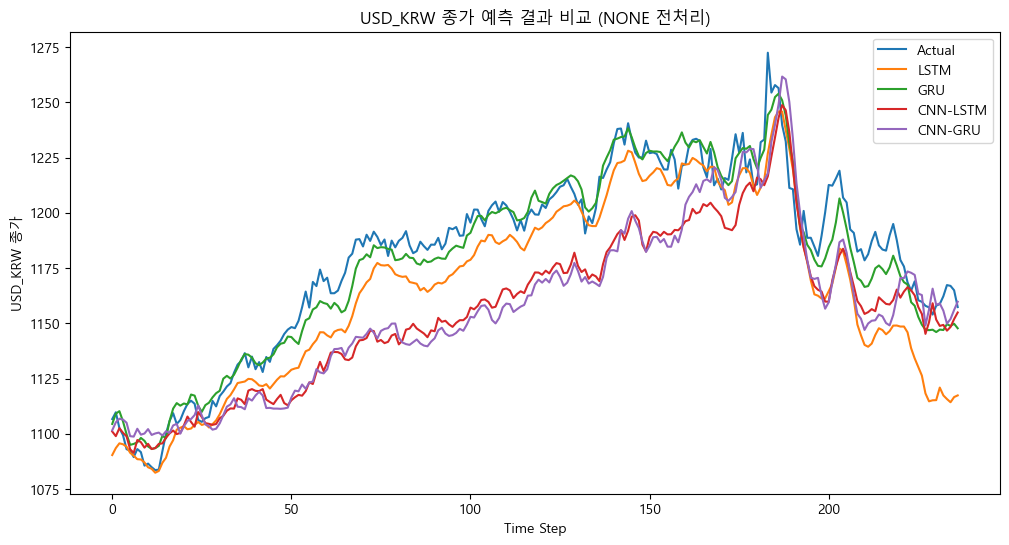

In [32]:
print("===== 시각화 =====")
raw_results = experiment_results_df9['pca']
plot_time_series_predictions(raw_results['y_test_inv'], raw_results['models'], method="none")